In [20]:
using ModelingToolkit, OrdinaryDiffEq, Plots, SciMLBase
using ModelingToolkit: t_nounits as t, D_nounits as D

In [2]:
include("models/rc_comps.jl")

ModelingToolkit.Model{typeof(__ConstantVoltage__), Dict{Symbol, Any}}(__ConstantVoltage__, Dict{Symbol, Any}(:equations => Any["v ~ V"], :kwargs => Dict{Symbol, Dict}(:V => Dict{Symbol, Union{Nothing, DataType}}(:value => nothing, :type => Real)), :independent_variable => t, :extend => Any[[:v], :oneport, :OnePort], :parameters => Dict{Symbol, Dict{Symbol, Any}}(:V => Dict(:type => Real))), false)

### .1 

In [21]:
@mtkmodel HeatingResistor begin    
    @extend i,v = oneport = OnePort()
    @components begin
        heat_port = HeatPort()
    end    
    @parameters begin
        R_ref = 1.0, [description = "Reference resistance"]
        T_ref = 300.15, [description = "Reference temperature"]
        alpha = 0, [description = "Temperature coefficient of resistance"]
        tau = 1e-3, [description = "Time constant for resistance change", guess=1e-3] # 引入时间常数
    end    
    @variables begin
        # R(t) = R_ref, [guess = R_ref, description = "Temperature dependent resistance"]
        R(t), [guess = R_ref, description = "Temperature dependent resistance"]
    end
    @equations begin        
        D(R) * tau ~ (R_ref * (1 + alpha * (heat_port.T - T_ref)) - R) 
        heat_port.Q_flow ~ -v * i        
        v ~ i * R
    end
end

ModelingToolkit.Model{typeof(__HeatingResistor__), Dict{Symbol, Any}}(__HeatingResistor__, Dict{Symbol, Any}(:equations => Any["D(R) * tau ~ R_ref * (1 + alpha * (heat_port.T - T_ref)) - R", "D(R) * tau ~ R_ref * (1 + alpha * (heat_port.T - T_ref)) - R", "heat_port.Q_flow ~ -v * i", "D(R) * tau ~ R_ref * (1 + alpha * (heat_port.T - T_ref)) - R", "heat_port.Q_flow ~ -v * i", "v ~ i * R"], :components => Any[Union{Expr, Symbol}[:heat_port, :HeatPort]], :variables => Dict{Symbol, Dict{Symbol, Any}}(:R => Dict(:type => Real, :description => "Temperature dependent resistance")), :kwargs => Dict{Symbol, Dict}(:alpha => Dict{Symbol, Any}(:value => 0, :type => Real), :T_ref => Dict{Symbol, Any}(:value => 300.15, :type => Real), :R => Dict{Symbol, Union{Nothing, DataType}}(:value => nothing, :type => Real), :R_ref => Dict{Symbol, Any}(:value => 1.0, :type => Real), :tau => Dict{Symbol, Any}(:value => 0.001, :type => Real)), :independent_variable => :t, :extend => Any[[:i, :v], :oneport, :OnePor

In [22]:
include("models/rc.jl")

ModelingToolkit.Model{typeof(__RcHeating__), Dict{Symbol, Any}}(__RcHeating__, Dict{Symbol, Any}(:components => Any[Union{Expr, Symbol}[:resistor, :HeatingResistor], Union{Expr, Symbol}[:capacitor, :Capacitor], Union{Expr, Symbol}[:source, :ConstantVoltage], Union{Expr, Symbol}[:ground, :Ground], Union{Expr, Symbol}[:fixedTemperature, :FixedTemperature]], :independent_variable => t, :equations => Any["connect(source.p, resistor.p)", "connect(source.p, resistor.p)", "connect(resistor.n, capacitor.p)", "connect(source.p, resistor.p)", "connect(resistor.n, capacitor.p)", "connect(capacitor.n, source.n, ground.p)", "connect(source.p, resistor.p)", "connect(resistor.n, capacitor.p)", "connect(capacitor.n, source.n, ground.p)", "connect(resistor.heat_port, fixedTemperature.port)"]), false)

In [23]:
@mtkbuild sys = RcHeating()

Model sys:
Equations (3):
  3 standard: see equations(sys)
Unknowns (3): see unknowns(sys)
  resistor₊R(t): Temperature dependent resistance
  capacitor₊v(t)
  resistor₊i(t)
Parameters (7): see parameters(sys)
  resistor₊alpha [defaults to 0]: Temperature coefficient of resistance
  fixedTemperature₊T: Fixed temperature boundary condition
  resistor₊tau [defaults to 0.001]: Time constant for resistance change
  source₊V
  ⋮
Observed (22): see observed(sys)

In [6]:
"""
sys, 5 subs [:resistor, :capacitor, :source, :ground, :fixedTemperature]
    resistor, 3 subs [:p, :n, :heat_port]
        p, 0 subs
        n, 0 subs
        heat_port, 0 subs
    capacitor, 2 subs [:p, :n]
        p, 0 subs
        n, 0 subs
    source, 2 subs [:p, :n]
        p, 0 subs
        n, 0 subs
    ground, 1 subs [:p]
        p, 0 subs
    fixedTemperature, 1 subs [:port]
        port, 0 subs

Unknowns (3)
    resistor₊R(t) ▪ Unassigned ▪ Temperature dependent resistance
    capacitor₊v(t) ▪ Unassigned ▪ Voltage drop of the two pins (= p.v - n.v)
    resistor₊i(t) ▪ Unassigned ▪ Current flowing from pin p to pin n
Parameters (7)
    resistor₊alpha ▪ 0 ▪ Temperature coefficient of resistance
    fixedTemperature₊T ▪ Unassigned ▪ Fixed temperature at port
    resistor₊tau ▪ 0.001 ▪ Time constant for resistance change
    source₊V ▪ Unassigned ▪ Value of constant voltage
    resistor₊R_ref ▪ 1.0 ▪ Reference resistance
    resistor₊T_ref ▪ 300.15 ▪ Reference temperature
    capacitor₊C ▪ Unassigned ▪ Capacitance
Equations (3)
    Differential(t)(resistor₊R(t)) ~ (-resistor₊R(t) + resistor₊R_ref*(1 + (-resistor₊T_ref + resistor₊heat_port₊T(t))*resistor₊alpha)) / resistor₊tau
    Differential(t)(capacitor₊v(t)) ~ capacitor₊i(t) / capacitor₊C
    0 ~ -resistor₊v(t) + resistor₊i(t)*resistor₊R(t)
"""
nothing

Core.nothing

In [26]:
tspan = (0.0, 15.0)

(0.0, 15.0)

#### (1) var style 1

In [38]:
state_var_ics = Dict(sys.capacitor.v => 0.0)

algebraic_guesses = Dict(
    sys.resistor.i => 0.0,
    sys.resistor.R => 1.0
)

paras = [
    sys.source.V => 1.0,
    sys.capacitor.C => 1.0,
    sys.fixedTemperature.T => 400.15,
    sys.resistor.alpha => 0.01,
    sys.resistor.R_ref => 1.0
]
paramap = Dict(p.first => p.second for p in paras)

Dict{Num, Float64} with 5 entries:
  fixedTemperature₊T => 400.15
  resistor₊alpha     => 0.01
  source₊V           => 1.0
  resistor₊R_ref     => 1.0
  capacitor₊C        => 1.0

In [36]:
prob = ODEProblem(sys, state_var_ics, tspan, paramap; 
                 guesses=algebraic_guesses, 
                 warn_initialize_determined = false)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
Initialization status: UNDERDETERMINED
Non-trivial mass matrix: true
timespan: (0.0, 15.0)
u0: 3-element Vector{Float64}:
 0.0
 0.0
 0.0

In [37]:
sysinit = prob.f.initializeprob.f.sys
sysinit_eqs = equations(sysinit)
if length(sysinit_eqs) != 0
    display("Initial equations:")
    @show sysinit_eqs
else
    display("No initial equations")
end

"Initial equations:"

sysinit_eqs = Equation[0 ~ -resistor₊v(t) + resistor₊i(t)*resistor₊R(t)]


1-element Vector{Equation}:
 0 ~ -resistor₊v(t) + resistor₊i(t)*resistor₊R(t)

In [33]:
@info "Starting ODE solve..."
sol = solve(prob, FBDF(); saveat = 0.1)
nothing

┌ Info: Starting ODE solve...
└ @ Main e:\Projects.jl\Reports.jl\mtk\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X20sZmlsZQ==.jl:1


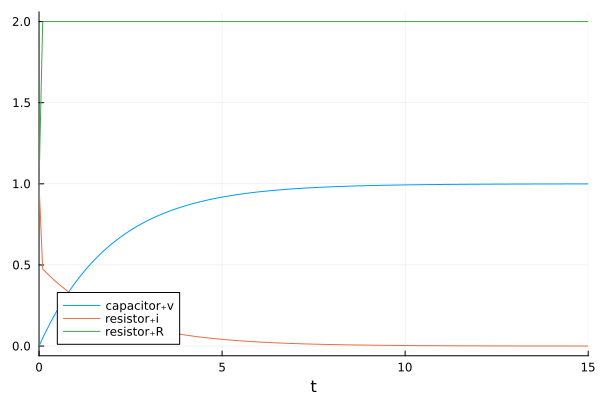

┌ Info: ODE solved successfully.
└ @ Main e:\Projects.jl\Reports.jl\mtk\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X21sZmlsZQ==.jl:2


In [34]:
if SciMLBase.successful_retcode(sol.retcode)
    @info "ODE solved successfully."
    plot(sol, idxs=[sys.capacitor.v, sys.resistor.i, sys.resistor.R]) |> display
else
    @error "ODE solve failed!" retcode=sol.retcode
end

#### (2) var style 2

In [ ]:
u0s12 = [sys.capacitor.v => 0.0]

algebraic_guesses12 = [
    sys.resistor.i => 0.0,
    sys.resistor.R => 1.0
]

paras12 = [
    sys.source.V => 1.0,
    sys.capacitor.C => 1.0,
    sys.fixedTemperature.T => 400.15,
    sys.resistor.alpha => 0.01,
    sys.resistor.R_ref => 1.0
]

5-element Vector{Pair{Num, Float64}}:
           source₊V => 1.0
        capacitor₊C => 1.0
 fixedTemperature₊T => 400.15
     resistor₊alpha => 0.01
     resistor₊R_ref => 1.0

In [41]:
prob12 = ODEProblem(sys, u0s12, tspan, paras12; 
                 guesses=algebraic_guesses12, 
                 warn_initialize_determined = false)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
Initialization status: UNDERDETERMINED
Non-trivial mass matrix: true
timespan: (0.0, 15.0)
u0: 3-element Vector{Float64}:
 0.0
 0.0
 0.0

In [46]:
sysinit12 = prob12.f.initializeprob.f.sys
sysinit_eqs12 = equations(sysinit12)
if length(sysinit_eqs12) != 0
    println("Initial equations:")
    sysinit_eqs12
else
    println("No initial equations")
end

Initial equations:


1-element Vector{Equation}:
 0 ~ -resistor₊v(t) + resistor₊i(t)*resistor₊R(t)

In [47]:
@info "Starting ODE solve..."
sol12 = solve(prob12, FBDF(); saveat = 0.1)
nothing

┌ Info: Starting ODE solve...
└ @ Main e:\Projects.jl\Reports.jl\mtk\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X31sZmlsZQ==.jl:1


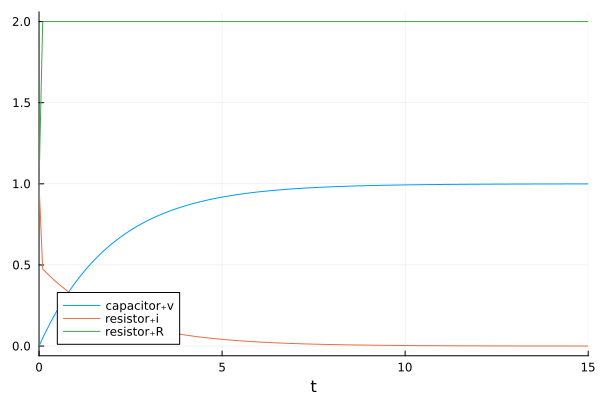

┌ Info: ODE solved successfully.
└ @ Main e:\Projects.jl\Reports.jl\mtk\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X32sZmlsZQ==.jl:2


In [48]:
if SciMLBase.successful_retcode(sol12.retcode)
    @info "ODE solved successfully."
    plot(sol12, idxs=[sys.capacitor.v, sys.resistor.i, sys.resistor.R]) |> display
else
    @error "ODE solve failed!" retcode=sol12.retcode
end

### .2

In [49]:
@mtkmodel HeatingResistor begin    
    @extend v, i = oneport = OnePort()
    @components begin        
        heat_port = HeatPort_a() # Note: This uses HeatPort_a, ensure compatibility or change if needed
    end
    @parameters begin
        R_ref = 1.0, [description = "Reference resistance"]
        T_ref = 300.15, [description = "Reference temperature"]
        alpha = 0, [description = "Temperature coefficient of resistance"]
    end
    @variables begin
        # Provide default value for R
        R(t) = R_ref, [guess = R_ref, description = "Algebraic resistance"]
    end
    @equations begin
        R ~ R_ref * (1 + alpha * (heat_port.T - T_ref))
        heat_port.Q_flow ~ -v * i # -LossPower
        v ~ i * R
    end
end

ModelingToolkit.Model{typeof(__HeatingResistor__), Dict{Symbol, Any}}(__HeatingResistor__, Dict{Symbol, Any}(:equations => Any["R ~ R_ref * (1 + alpha * (heat_port.T - T_ref))", "R ~ R_ref * (1 + alpha * (heat_port.T - T_ref))", "heat_port.Q_flow ~ -v * i", "R ~ R_ref * (1 + alpha * (heat_port.T - T_ref))", "heat_port.Q_flow ~ -v * i", "v ~ i * R"], :components => Any[Union{Expr, Symbol}[:heat_port, :HeatPort_a]], :variables => Dict{Symbol, Dict{Symbol, Any}}(:R => Dict(:default => :R_ref, :type => Real, :description => "Algebraic resistance")), :kwargs => Dict{Symbol, Dict}(:alpha => Dict{Symbol, Any}(:value => 0, :type => Real), :T_ref => Dict{Symbol, Any}(:value => 300.15, :type => Real), :R => Dict{Symbol, Any}(:value => :R_ref, :type => Real), :R_ref => Dict{Symbol, Any}(:value => 1.0, :type => Real)), :independent_variable => :t, :extend => Any[[:v, :i], :oneport, :OnePort], :parameters => Dict{Symbol, Dict{Symbol, Any}}(:alpha => Dict(:default => 0, :type => Real, :description =

In [50]:
include("models/rc.jl")

ModelingToolkit.Model{typeof(__RcHeating__), Dict{Symbol, Any}}(__RcHeating__, Dict{Symbol, Any}(:components => Any[Union{Expr, Symbol}[:resistor, :HeatingResistor], Union{Expr, Symbol}[:capacitor, :Capacitor], Union{Expr, Symbol}[:source, :ConstantVoltage], Union{Expr, Symbol}[:ground, :Ground], Union{Expr, Symbol}[:fixedTemperature, :FixedTemperature]], :independent_variable => t, :equations => Any["connect(source.p, resistor.p)", "connect(source.p, resistor.p)", "connect(resistor.n, capacitor.p)", "connect(source.p, resistor.p)", "connect(resistor.n, capacitor.p)", "connect(capacitor.n, source.n, ground.p)", "connect(source.p, resistor.p)", "connect(resistor.n, capacitor.p)", "connect(capacitor.n, source.n, ground.p)", "connect(resistor.heat_port, fixedTemperature.port)"]), false)

In [51]:
@mtkbuild sys2 = RcHeating()

Model sys2:
Equations (2):
  2 standard: see equations(sys2)
Unknowns (2): see unknowns(sys2)
  capacitor₊v(t)
  resistor₊i(t)
Parameters (6): see parameters(sys2)
  resistor₊alpha [defaults to 0]: Temperature coefficient of resistance
  fixedTemperature₊T: Fixed temperature boundary condition
  source₊V
  resistor₊R_ref [defaults to 1.0]: Reference resistance
  ⋮
Observed (23): see observed(sys2)

In [ ]:
"""
sys2, 5 subs [:resistor, :capacitor, :source, :ground, :fixedTemperature]
    resistor, 3 subs [:p, :n, :heat_port]
        p, 0 subs
        n, 0 subs
        heat_port, 0 subs
    capacitor, 2 subs [:p, :n]
        p, 0 subs
        n, 0 subs
    source, 2 subs [:p, :n]
        p, 0 subs
        n, 0 subs
    ground, 1 subs [:p]
        p, 0 subs
    fixedTemperature, 1 subs [:port]
        port, 0 subs
Unknowns (2)
    capacitor₊v(t) ▪ Unassigned ▪ Voltage drop of the two pins (= p.v - n.v)
    resistor₊i(t) ▪ Unassigned ▪ Current flowing from pin p to pin n
Parameters (6)
    resistor₊alpha ▪ 0 ▪ Temperature coefficient of resistance
    fixedTemperature₊T ▪ Unassigned ▪ Fixed temperature at port
    source₊V ▪ Unassigned ▪ Value of constant voltage
    resistor₊R_ref ▪ 1.0 ▪ Reference resistance
    resistor₊T_ref ▪ 300.15 ▪ Reference temperature
    capacitor₊C ▪ Unassigned ▪ Capacitance
Equations (2)
    Differential(t)(capacitor₊v(t)) ~ capacitor₊i(t) / capacitor₊C
    0 ~ -resistor₊v(t) + resistor₊i(t)*resistor₊R(t)
"""
nothing

In [ ]:
u0s2 = [sys.capacitor.v => 0.0]

# Set algebraic variable guesses (NECESSARY)
algebraic_guesses2 = [
    sys2.resistor.i => 0.0,
    sys2.resistor.R => 1.0 
]

# Set parameters
paras2 = [
    sys2.source.V => 1.0,
    sys2.capacitor.C => 1.0,
    sys2.fixedTemperature.T => 400.15,
    sys2.resistor.alpha => 0.01,
    sys2.resistor.R_ref => 1.0
]
paramap2 = Dict(p.first => p.second for p in paras)

In [ ]:
prob2 = ODEProblem(sys2, u0s2, tspan, paramap2; 
                 guesses=algebraic_guesses2, 
                 warn_initialize_determined = false)

In [ ]:
sysinit2 = prob2.f.initializeprob.f.sys
sysinit_eqs2 = equations(sysinit2)
if length(sysinit_eqs2) != 0
    println("Initial equations")
    sysinit_eqs2
else
    println("No initial equations")
end

In [ ]:
@info "Starting ODE solve..."
sol2 = solve(prob2, FBDF(); saveat = 0.1)
nothing

In [ ]:
if SciMLBase.successful_retcode(sol2.retcode)
    @info "ODE solved successfully."
    # Plot capacitor voltage, resistor current, and resistor algebraic value R
    plot(sol2, idxs=[sys2.capacitor.v, sys2.resistor.i, sys2.resistor.R]) |> display
else
    @error "ODE solve failed!" retcode=sol2.retcode
end

<img src="images/right_algebracic_gesses.png">

In [ ]:
u0s2 = [sys2.capacitor.v => 0.0]

# 3. Set algebraic variable guesses (CONSISTENT with t=0 physics)
algebraic_guesses2 = [
    sys2.resistor.i => 0.5, # Consistent initial current guess
    sys2.resistor.R => 2.0  # Consistent initial resistance guess
]
# 还是不行